In [1]:
########################################################################################################################
# Imports
########################################################################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from tqdm import tqdm, tqdm_notebook
import imageio
import cv2

from keras.models import load_model
from keras import backend as K

import keras.models as models
from keras.models import Model

########################################################################################################################
# Import Function definitions
########################################################################################################################
from ShipSegFunctions import *

Using TensorFlow backend.


In [2]:
########################################################################################################################
# GPU info
########################################################################################################################import tensorflow as tf
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(device_count = {'GPU': 0}) # Use CPU for the testing
# config = tf.ConfigProto() # Use GPU
# config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
# print(device_lib.list_local_devices())
# print(K.tensorflow_backend._get_available_gpus())


In [3]:
########################################################################################################################
# PARAMETERS
########################################################################################################################
# Data on AWS
image_path = "/data/train_v2"
segmentation_data_file_path = '/data/train_ship_segmentations_v2.csv'
model_path = ""
# Data locally
# image_path = "/run/media/kalap/Storage/Deep learning 2/train_v2"
# segmentation_data_file_path = '/run/media/kalap/Storage/Deep learning 2/train_ship_segmentations_v2.csv'
# Data on Github
# image_path = "../data/train_img"
# segmentation_data_file_path = '../data/train_ship_segmentations_v2.csv'

valid_split = 0.15
test_split = 0.15

# resize_img_to = (768, 768)
# resize_img_to = (384, 384)
# resize_img_to = (256, 256)
resize_img_to = (192, 192)
batch_size = 16

In [4]:
########################################################################################################################
# Load and prepare the data
########################################################################################################################

# Load the file which contains the masks for each image
df_train = pd.read_csv(segmentation_data_file_path)

# Load the test data ids saved by the Train file
test_img_ids = np.load(model_path + "test_img_ids.npy")

#######################################################################################################################
# Load the network
########################################################################################################################
model = load_model(model_path + "model.hdf5", custom_objects={'dice_coef_loss': dice_coef_loss})
print(model.summary())

test_generator = DataGenerator(
    test_img_ids,
    df_train,
    image_path,
    batch_size=batch_size,
    dim=resize_img_to,
    shuffle_on_every_epoch=False,
    shuffle_on_init=False,
    split_to_sub_img=False
)


# predictions = model.predict_generator(test_generator,
#                                       steps=1, verbose =1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [33]:
tmp_images, tmp_masks_true = test_generator.__getitem__(0)

tmp_ids, unique_ids = np.unique(test_generator.get_last_batch_ImageIDs(), return_index=True, axis=0)
tmp_images = tmp_images[unique_ids]
tmp_masks_true = tmp_masks_true[unique_ids]

predictions_tmp = model.predict(tmp_images, verbose=1)
test_images = tmp_images
test_mask_true = tmp_masks_true
predictions = predictions_tmp

test_ratio = 0.01
for i in tqdm(range(2,int(test_ratio * len(test_img_ids)/batch_size)+2)):
    tmp_images, tmp_masks_true = test_generator.__getitem__(i)
   
    tmp_ids, unique_ids = np.unique(test_generator.get_last_batch_ImageIDs(), return_index=True, axis=0)
    tmp_images = tmp_images[unique_ids]
    tmp_masks_true = tmp_masks_true[unique_ids]
    
    predictions_tmp = model.predict(tmp_images, verbose=0)
    
    test_images = np.concatenate((test_images, tmp_images), axis=0)
    test_mask_true = np.concatenate((test_mask_true, tmp_masks_true), axis=0)
    predictions = np.concatenate((predictions, predictions_tmp), axis=0)    

9/9 [==============================] - 25s 3s/step




  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:22<02:17, 22.99s/it]

 29%|██▊       | 2/7 [00:54<02:07, 25.47s/it]

 43%|████▎     | 3/7 [01:22<01:45, 26.31s/it]

 57%|█████▋    | 4/7 [02:04<01:33, 31.13s/it]

 71%|███████▏  | 5/7 [02:33<01:00, 30.24s/it]

 86%|████████▌ | 6/7 [03:01<00:29, 29.71s/it]

100%|██████████| 7/7 [03:27<00:00, 28.54s/it]



(82, 192, 192, 1)


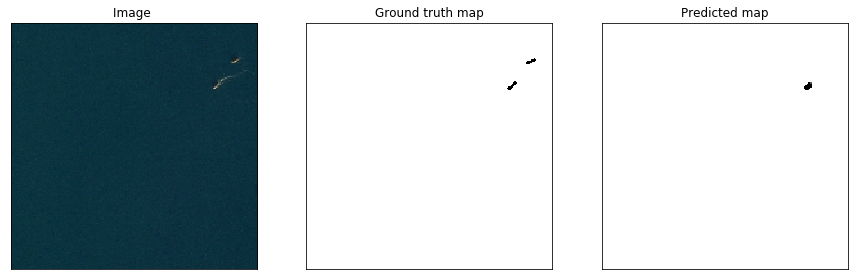

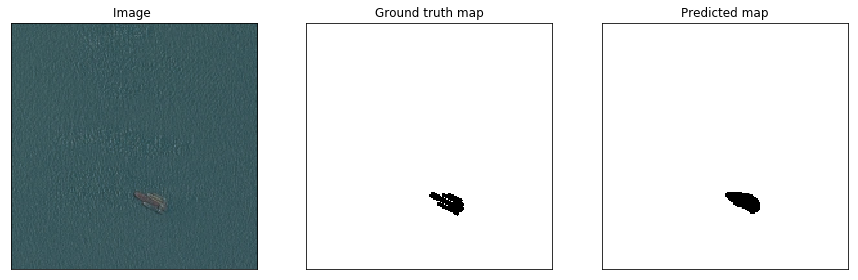

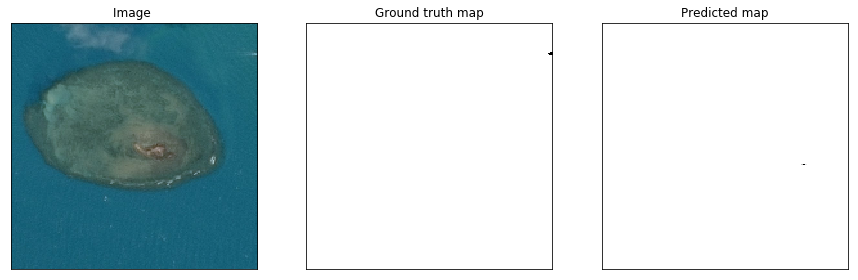

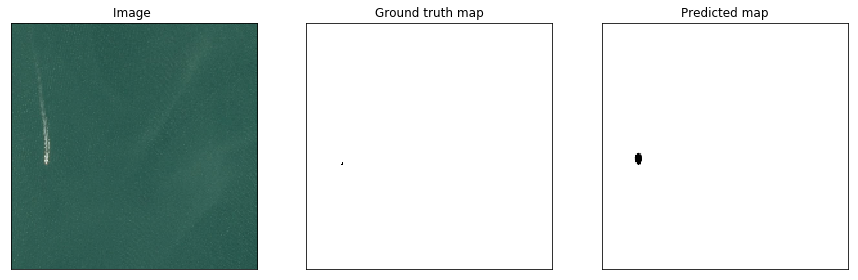

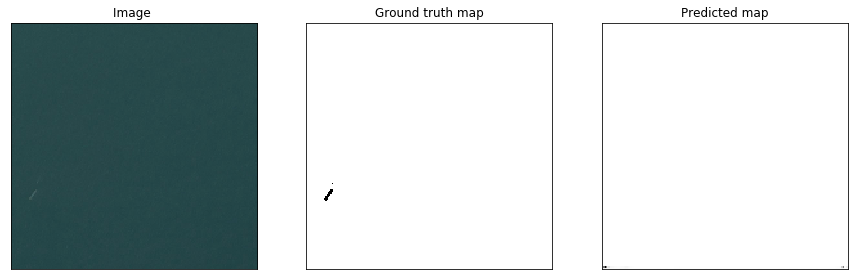

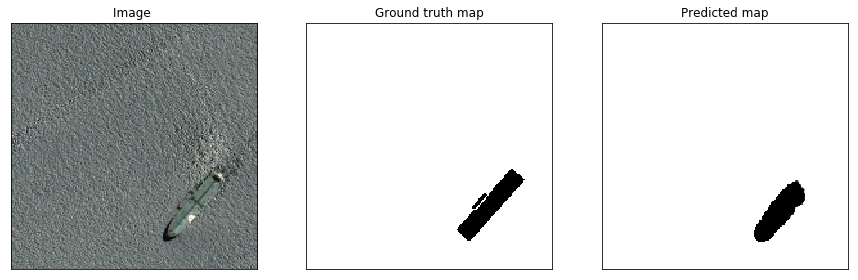

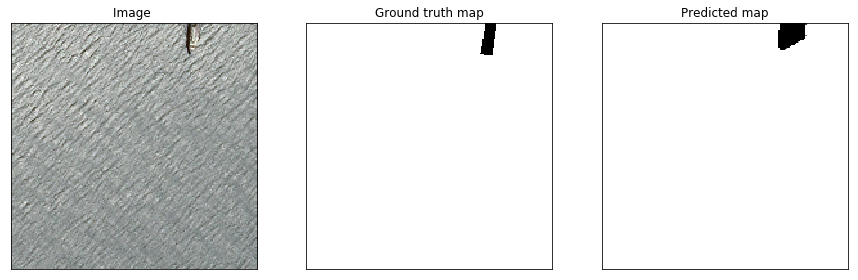

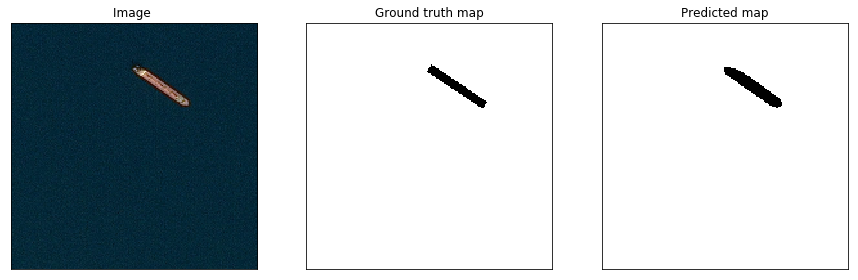

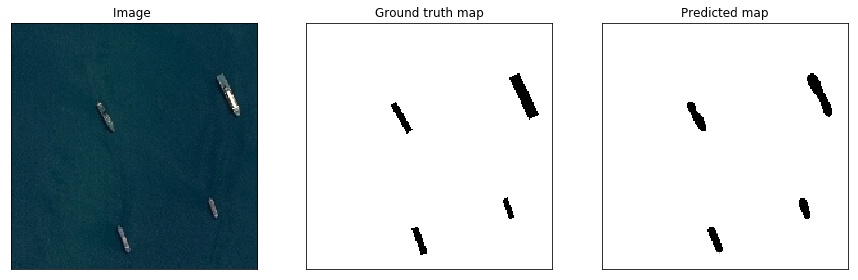

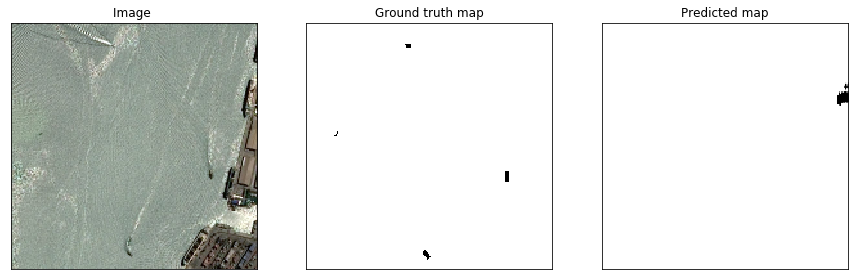

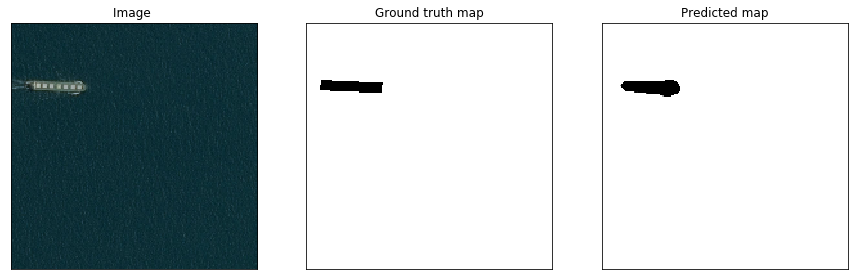

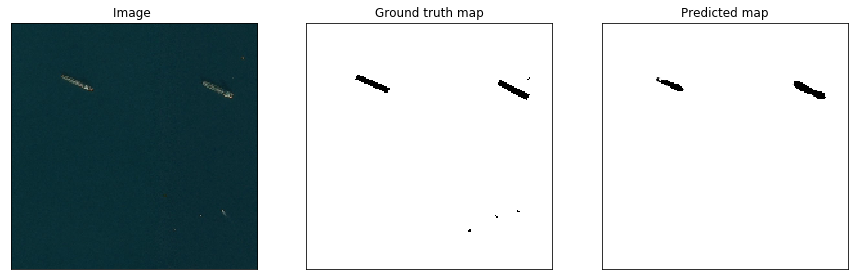

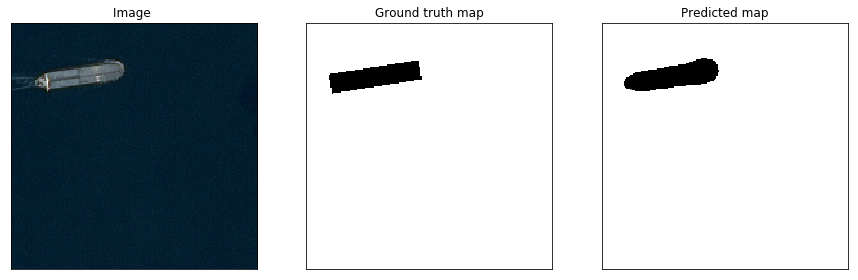

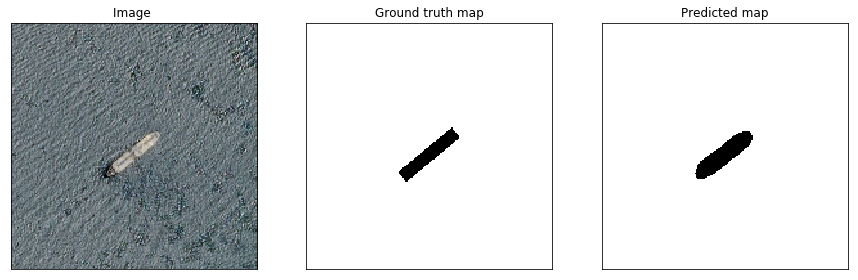

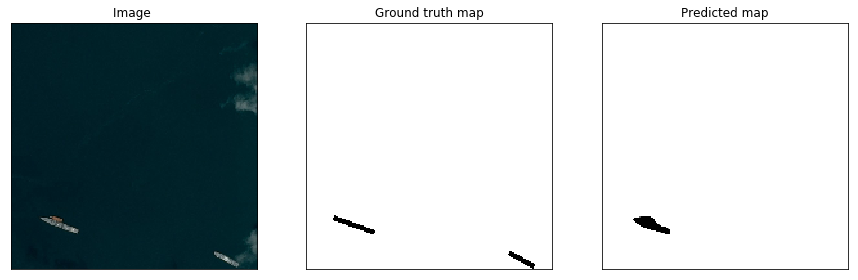

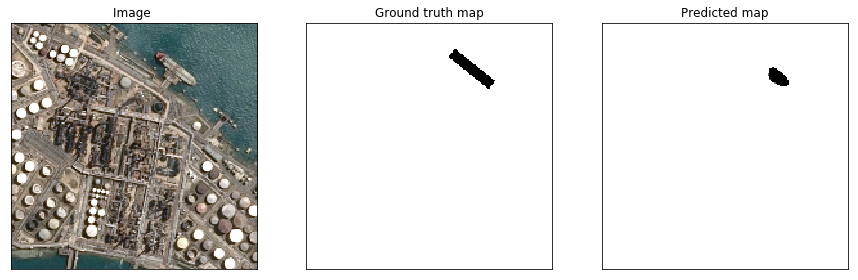

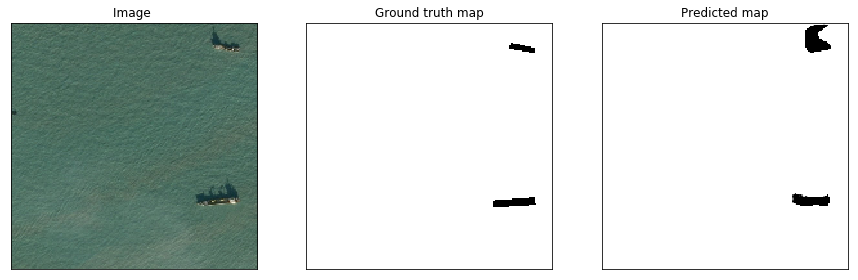

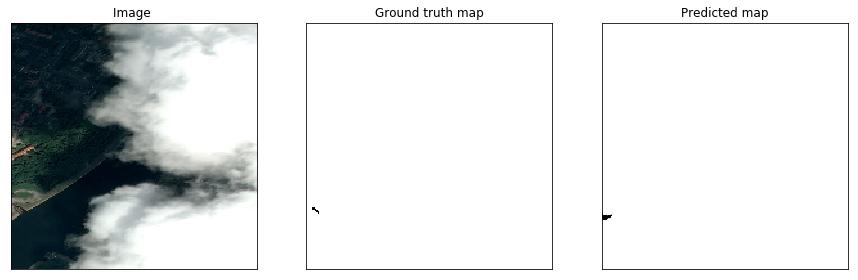

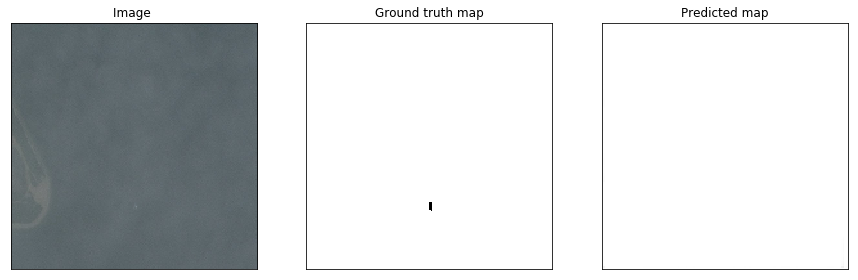

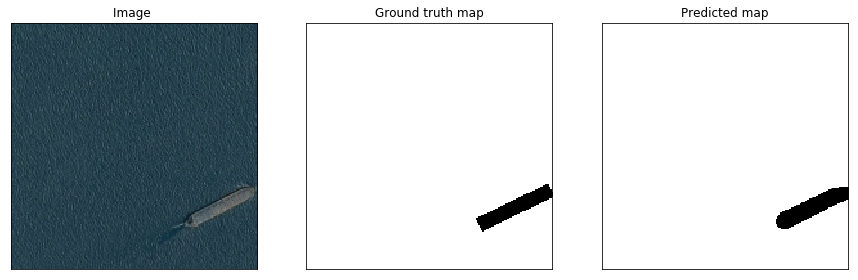

In [34]:
print(predictions.shape)
for i in range(20):
    disp_image_with_map2(test_images[i], test_mask_true[i], predictions[i])

Normalized confusion matrix
[[ 0.99765144  0.00234856]
 [ 0.31027021  0.68972979]]


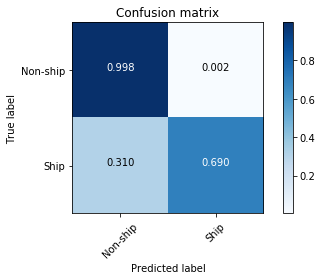

In [35]:
from sklearn.metrics import confusion_matrix
threshold = 0.5
predictions = (predictions>threshold).astype(int)

conf = confusion_matrix(test_mask_true.flatten(),predictions.flatten());
plot_confusion_matrix(conf,classes=["Non-ship", "Ship"], normalize=True);
plt.show()

In [46]:
from sklearn.metrics import jaccard_similarity_score, f1_score, balanced_accuracy_score
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(np.multiply(y_true_f,y_pred_f))
    return (2.0 * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

jaccard = jaccard_similarity_score(test_mask_true.flatten(),predictions.flatten())
balanced = balanced_accuracy_score(test_mask_true.flatten(),predictions.flatten())
f1 = f1_score(test_mask_true.flatten(),predictions.flatten())
dice = dice_coef_np(test_mask_true,predictions)
print("Jaccard similarity score: ", jaccard)
print("Balanced accuracy score:", balanced)
print("F1 similarity score: ", f1)
print("Dice coefficient", dice)

Jaccard similarity score:  0.995815535548
Balanced accuracy score: 0.84369061682
F1 similarity score:  0.662792247607
Dice coefficient 0.662801236938
